In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from datetime import datetime, timedelta

from setup.univ_setup import *
from setup.utils import *
from factor_mining.combine_factors import *
from factor_mining.factor_preprocessing import *
from performance_analysis.pa_core import *

from backtest.BackTestSinglePeriod import *
from backtest.BackTest import *
from backtest.percentile_portfolio import *

from factor_mining.attribution.factor_correlation import *

warnings.filterwarnings("ignore")

In [2]:
### universe setup ###
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
univ = univ_setup(datadir, silent=False)
filt_na(univ)

### model configuration ###
print('Calculate factors')
# define and calculate all factors
from factor_mining.factors.momentum import *
from factor_mining.factors.simple_factor import *
factors = {}
factors['beta'] = simple_factor(univ, 'beta')
factors['vol60'] = simple_factor(univ, 'vol60')
factors['log_market_cap'] = simple_factor_1step_math(univ, 'market_cap', np.log)

from itertools import product

for short, long in product([4, 6], [26, 52, 78]):
    factors['momentum_%s_%s' % (short, long)] = momentum(univ, short, long, naming='full')
    factor_names = list(factors.keys())

# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)
filt_na(factor_exp_mat)

### Filt the illiquid names within universe ###
print('Filt the untradables')

filt_byval(univ, 'in_r3000', 0)
filt_byval(univ, 'not_in_MA', 0)
filt_byval(univ, 'price', 10)
filt_byval(univ, 'volume', 1500000)
factor_exp_mat = merge(factor_exp_mat, univ, right_cols=['f_log_ret_1', 'industry'])

# Preprocessing factor expsure matrices
print('Scale each factor')
factor_exp_mat = process_batch(factor_exp_mat, standardize, factor_names=factor_names)
print('Winsorize with +/- 3 std')
factor_exp_mat = process_batch(factor_exp_mat, winsorize_std, factor_names=factor_names)
print('Done')

Setup R3000 universe
use existing binary file
0.554391 seconds
Calculate factors
Filt the untradables
Scale each factor
Winsorize with +/- 3 std
Done


In [3]:
datelst = sorted(univ.keys())
print(datelst[0], datelst[-1])
start_date = datetime(2012, 1, 1)
end_date = datetime(2016, 12, 31)
# crdf = factor_correlation(univ, factor_exp_mat, lag = 0, demean='industry')

2010-04-30 00:00:00 2017-04-28 00:00:00


In [18]:
%%time
step = 10
pctcut = range(0, 100 + step, step)
iter_result = {}
allshort, alllong = [4, 6], [26, 52, 78]
for short, long in product(allshort, alllong):
    print(short, long)
    for rg_low, rg_high in zip(pctcut[:-1], pctcut[1:]):
        spcalc = PercentilePtflSpcalc(signal='momentum_%s_%s' % (short, long), sel_range=[rg_low, rg_high])
        bt = BackTest(univ=univ, factor_exp_mat=factor_exp_mat, daterange=[start_date, end_date], sp_calc=spcalc, rebal=26)
        ptfl_lst, pnl_lst = bt.calc_pnl()
        pnl_lst = pnl_lst['pnl']
        iter_result['momentum_%s_%s_%s_%s' % (short, long, rg_low, rg_high)] = (np.nanmean(pnl_lst), np.sqrt(np.nanvar(pnl_lst)))
    

4 26
4 52
4 78
6 26
6 52
6 78
CPU times: user 2min 25s, sys: 12 ms, total: 2min 25s
Wall time: 2min 25s


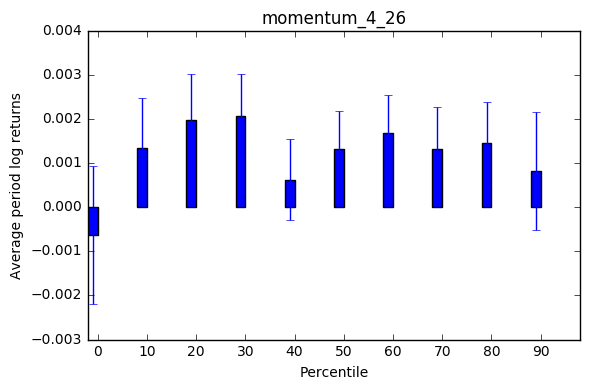

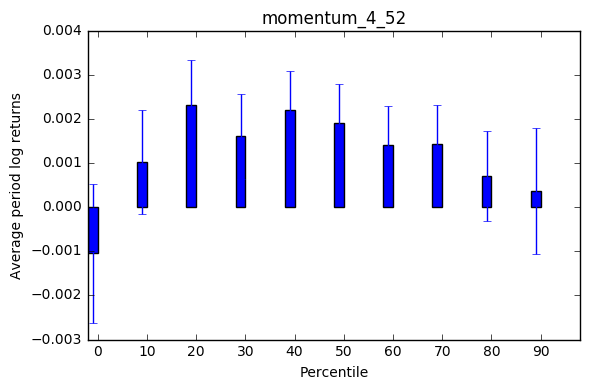

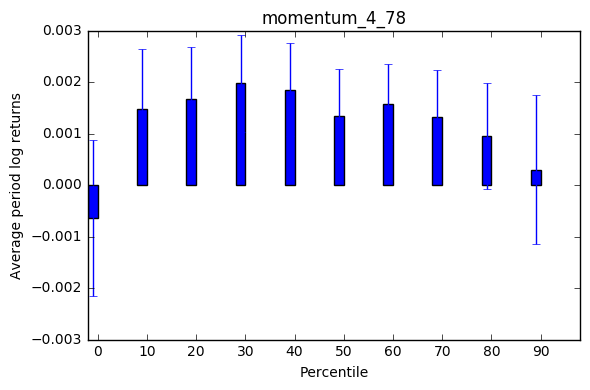

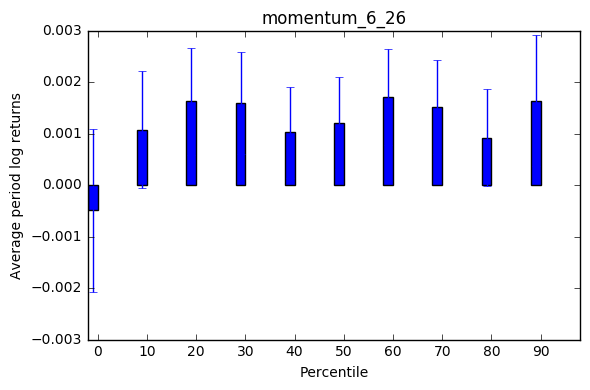

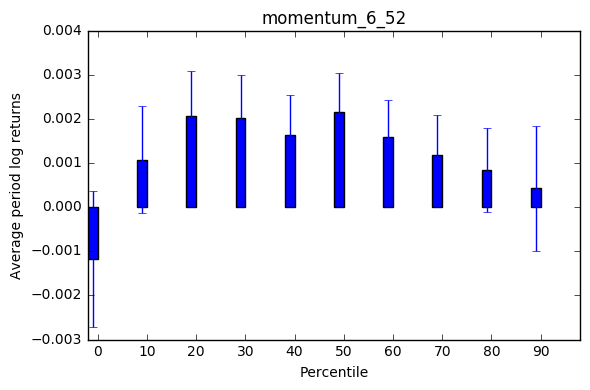

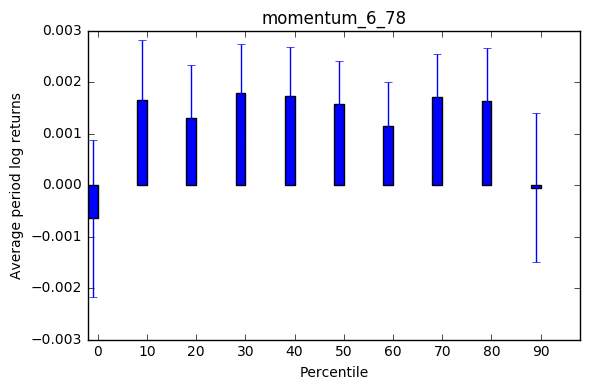

In [19]:
c = len(pnl_lst)
for short, long in product(allshort, alllong):
    k = 'momentum_%s_%s' % (short, long)
    x = pctcut[:-1]
    y = [iter_result[k + '_%s_%s' % (rg_low, rg_high)][0] for rg_low, rg_high in zip(pctcut[:-1], pctcut[1:])]
    s = [iter_result[k + '_%s_%s' % (rg_low, rg_high)][1] / np.sqrt(c) for rg_low, rg_high in zip(pctcut[:-1], pctcut[1:])]
    
    bar_width = 2
    week = plt.bar(np.array(x), y, width=bar_width, yerr=s, color='b')

    plt.xlabel('Percentile')
    plt.ylabel('Average period log returns')
    plt.title(k)
    plt.xticks(np.array(x) + bar_width, x)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [23]:
df = get_val(factor_exp_mat, 330)

In [27]:
df.sort('momentum_4_52', ascending=False)

,date,ticker,vol60,momentum_6_52,momentum_4_78,momentum_4_52,momentum_6_78,log_market_cap,beta,momentum_4_26,momentum_6_26,f_log_ret_1,industry
189,2016-08-26,FIZZ,0.194798,2.999987,2.999991,2.999988,2.999990,-0.425533,-0.873185,1.041352,1.577924,-0.039977,"Consumer, Non-cyclical"
85,2016-08-26,CDE,1.464772,2.999987,2.999991,2.999988,2.999990,-0.475698,-0.154418,2.999984,2.999980,-0.013986,Basic Materials
200,2016-08-26,FPRX,0.822524,2.999987,2.277551,2.999988,1.808438,-0.927893,0.828550,1.218533,0.737629,-0.021053,"Consumer, Non-cyclical"
455,2016-08-26,STS,2.409775,2.207000,2.455923,2.954948,1.807996,-2.134989,-0.642927,2.999984,2.270500,0.062646,"Consumer, Cyclical"
437,2016-08-26,SHEN,1.093459,2.999987,2.999991,2.848711,2.999990,-0.954671,0.170672,2.003607,2.347287,0.029924,Communications
210,2016-08-26,GIMO,0.465385,1.912437,2.999991,2.640320,2.425826,-0.756938,2.013431,1.777514,1.072359,0.003600,Communications
294,2016-08-26,LOCK,-0.375074,2.524180,0.366490,2.543268,0.315132,-0.755734,0.202866,1.023124,1.010286,0.001181,"Consumer, Non-cyclical"
222,2016-08-26,HA,-0.082559,2.556180,2.999991,2.524488,2.999990,-0.405075,1.805220,-0.386040,-0.458657,0.047321,"Consumer, Cyclical"
48,2016-08-26,BCOV,0.488990,2.202632,0.722383,2.470389,0.526713,-1.829449,0.617190,1.957393,1.731734,0.064488,Technology
233,2016-08-26,HMSY,-0.037779,2.160154,0.209913,2.276140,0.109321,-0.628829,0.649034,1.134852,1.038335,0.020488,"Consumer, Non-cyclical"


In [28]:
df[df.ticker=='INTC']

,date,ticker,vol60,momentum_6_52,momentum_4_78,momentum_4_52,momentum_6_78,log_market_cap,beta,momentum_4_26,momentum_6_26,f_log_ret_1,industry
